In [1]:
from tensorflow.keras.datasets import mnist
import torchvision
from torchvision import transforms
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import time

## Preparing Data

### Loading in, normalizing, and separating data by class

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Conversion to float
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
# Normalization
x_train = x_train/255.0
x_test = x_test/255.0


X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


In [4]:
# What is being done here:
# We are collecting all the images by classes
# Each entry in the 'digits' list is 
# a numpy array of all the images by class

digits = []
test_digits = []
for i in range(10):
    classno = X_train[np.where(y_train==i)]
    digits.append(classno)
    classno = X_test[np.where(y_test==i)]
    test_digits.append(classno)

### Generating Adversarial Samples

In [5]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Epoch 0 - Training loss: 0.345661859165059
Epoch 1 - Training loss: 0.14307951917355535
Epoch 2 - Training loss: 0.09619204392597111
Epoch 3 - Training loss: 0.07358390065098702
Epoch 4 - Training loss: 0.058410129006475464
Epoch 5 - Training loss: 0.04652725768001027
Epoch 6 - Training loss: 0.03589207160116326
Epoch 7 - Training loss: 0.030219801881999426
Epoch 8 - Training loss: 0.02703641941830484
Epoch 9 - Training loss: 0.020437299695820598
Epoch 10 - Training loss: 0.018124589386607964
Epoch 11 - Training loss: 0.01658357478065619
Epoch 12 - Training loss: 0.014760744783703162
Epoch 13 - Training loss: 0.014387495920200387
Epoch 14 - Training loss: 0.010694580427651144

Training Time (in minutes) = 0.31961913108825685
Predicted Digit = 4
Number Of Images Tested = 10000

Model Accuracy = 0.9786


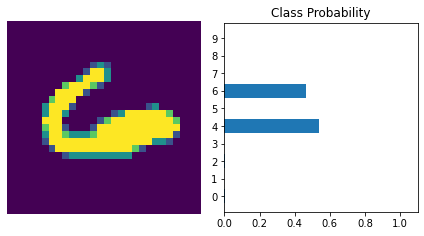

In [6]:
# Now let's start training the network

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

def train_model(model, x_train, x_test, y_train, y_test, epochs=15):
    transform = transforms.Compose([transforms.Normalize((0,), (1,)),])
    
    #trainset = datasets.MNIST('../', download=True, train=True, transform=transform)
    #valset = datasets.MNIST('../', download=True, train=False, transform=transform)
    trainset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train).type(torch.long))
    valset = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test).type(torch.long))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

    criterion = nn.NLLLoss()
    images, labels = next(iter(trainloader))
    images = images.view(images.shape[0], -1)
    labels = labels

    logps = model(images)
    loss = criterion(logps, labels)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    time0 = time()
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:

            images = images.view(images.shape[0], -1)
            labels = labels

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)


    images, labels = next(iter(valloader))

    img = images[0].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    print("Predicted Digit =", probab.index(max(probab)))
    view_classify(img.view(1, 28, 28), ps)

    correct_count, all_count = 0, 0
    for images,labels in valloader:
        for i in range(len(labels)):
            img = images[i].view(1, 784)
            with torch.no_grad():
                logps = model(img)


            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", (correct_count/all_count))
    
    return model
    
model = train_model(model, X_train, X_test, y_train, y_test, epochs=15)

In [7]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
# Let's create adversarial examples
eps = 0.1
adv_digits = list()
adv_digits_test = list()
for i in range(10):
    adv_digits.append(fast_gradient_method(model, torch.from_numpy(digits[i]), eps, np.inf).detach().numpy())
    adv_digits_test.append(fast_gradient_method(model, torch.from_numpy(test_digits[i]), eps, np.inf).detach().numpy())

In [8]:
def one_vs_all_digits(data, labels, network, digit):
    """ Function to return the network outputs of images belonging to a particular digit
        vs network outputs of images belonging to all other classes. Images of the digit 
        passed in as the fourth parameter are labeled 1 and images of all other digits 
        are labeled 0.
    """
    curr_digit = data[np.where(labels==digit)]
    other_digits = data[np.where(labels!=digit)]
    
    labels = np.concatenate((np.zeros((len(other_digits)), dtype=int), 
                             np.ones((len(curr_digit)), dtype=int)))
    
    train = np.concatenate((other_digits, curr_digit))
    
    trainset = torch.utils.data.TensorDataset(torch.Tensor(train), torch.Tensor(labels).type(torch.long))
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
    
    network_outputs = list()
    labels = list()
    with torch.no_grad():
        for x, y in trainloader:
            network_outputs.append(network(x))
            labels.append(y)
            
    network_outputs = np.concatenate(network_outputs)
    labels = np.concatenate(labels)
    
    return network_outputs, labels

In [9]:
digit = 0
train, train_labels = one_vs_all_digits(X_train, y_train, model, digit)
test, test_labels = one_vs_all_digits(X_test, y_test, model, digit)

### Plotting one-vs-all network outputs in TSNE plot

In [10]:
from sklearn.manifold import TSNE
tsne_points = TSNE(n_components=2, perplexity = 50, n_iter = 2000).fit_transform(test)

/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


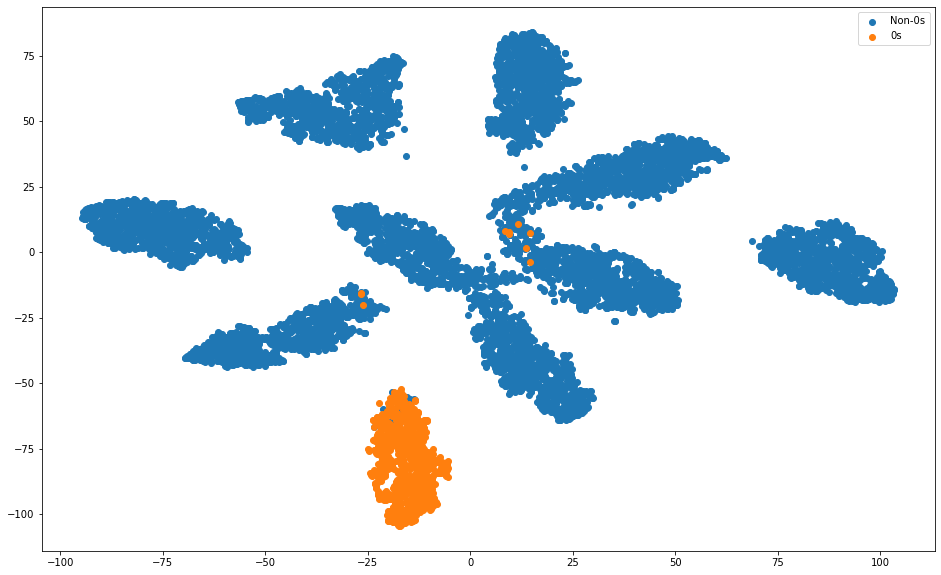

In [11]:
boundary = len(test_labels) - test_labels.sum().item()

plt.figure(figsize=(16,10))
plt.scatter(tsne_points[:boundary,0], tsne_points[:boundary,1], label="Non-" + str(digit) + "s")
plt.scatter(tsne_points[boundary:,0], tsne_points[boundary:,1], label=str(digit) + "s")
plt.legend()

/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


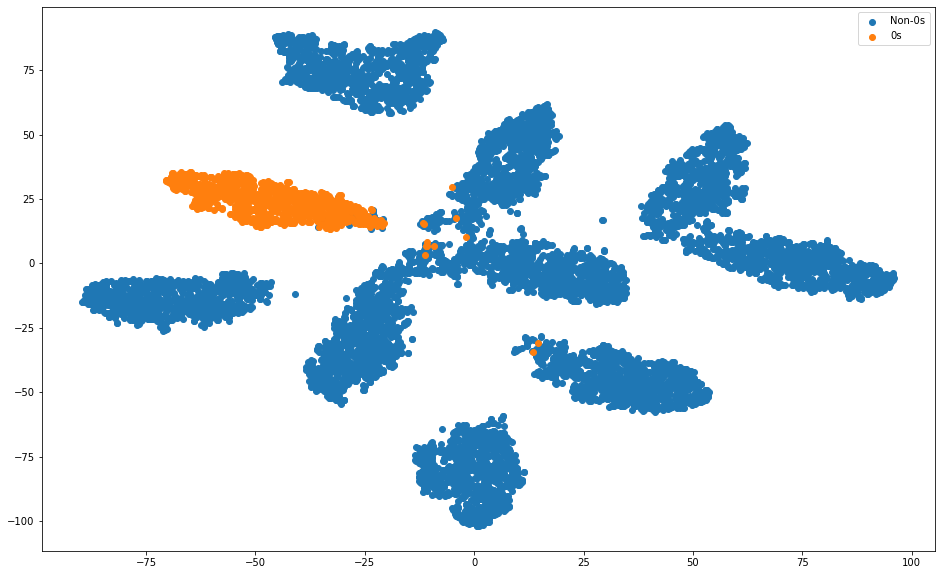

/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

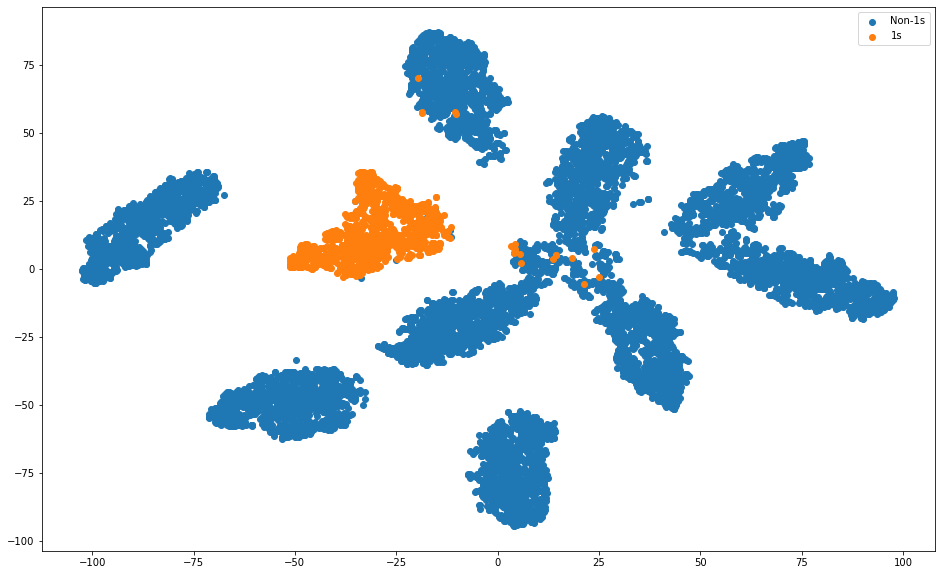

/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

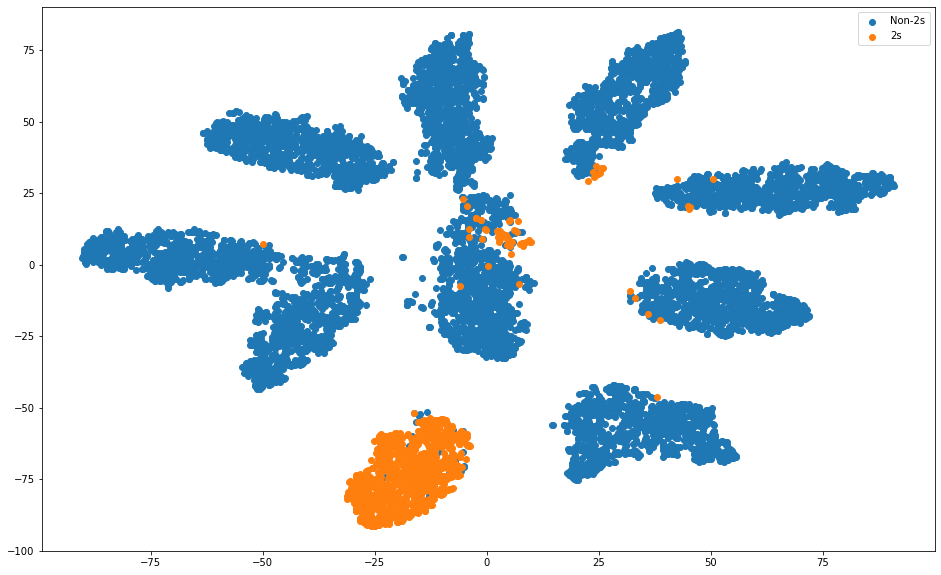

/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

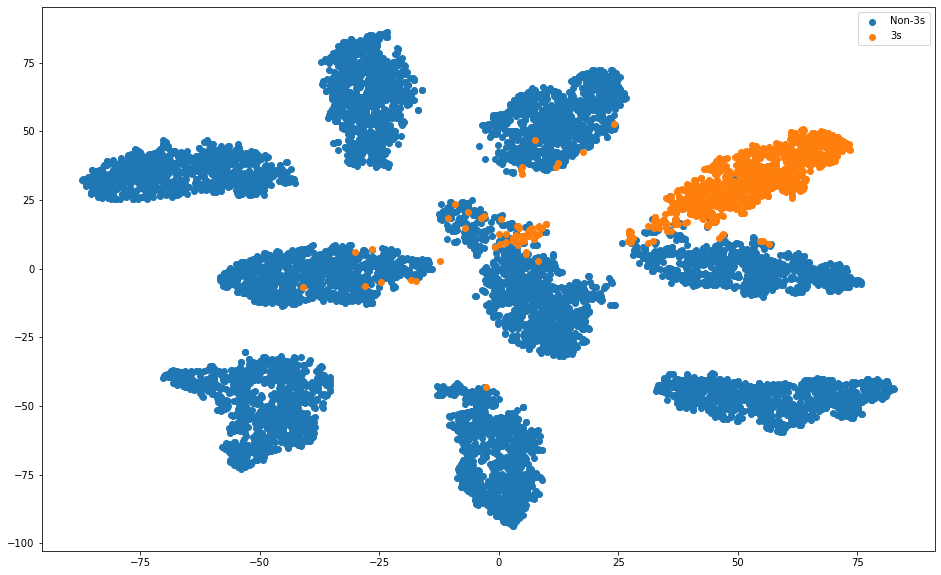

/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

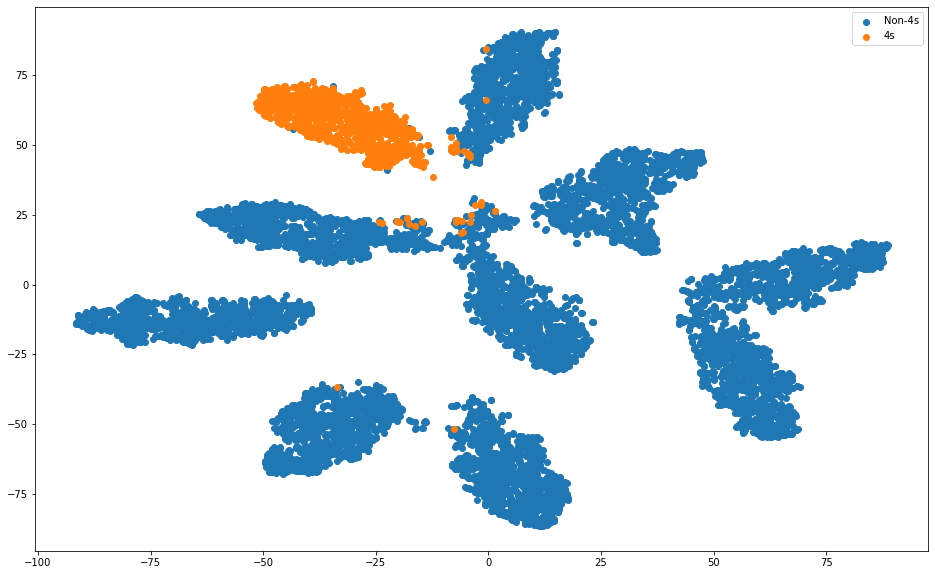

/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

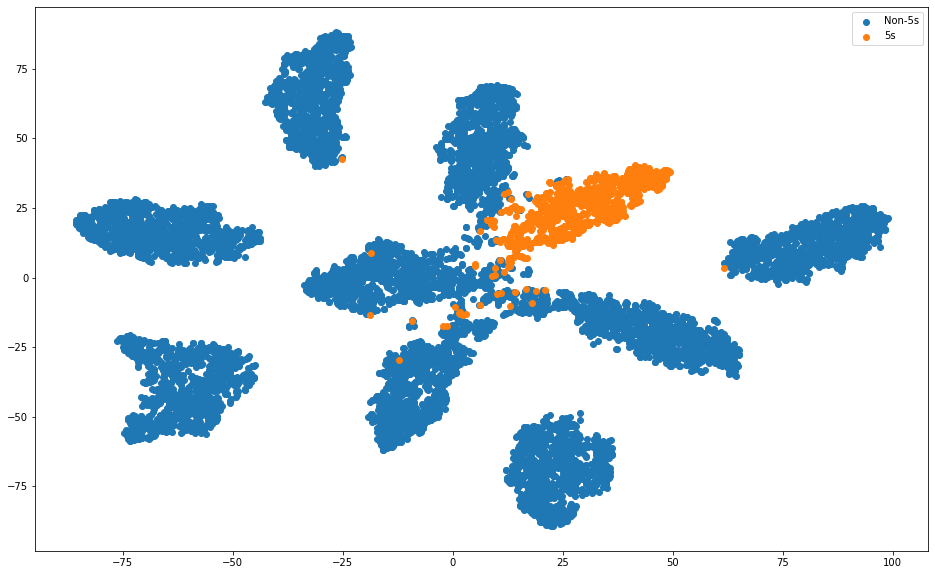

/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

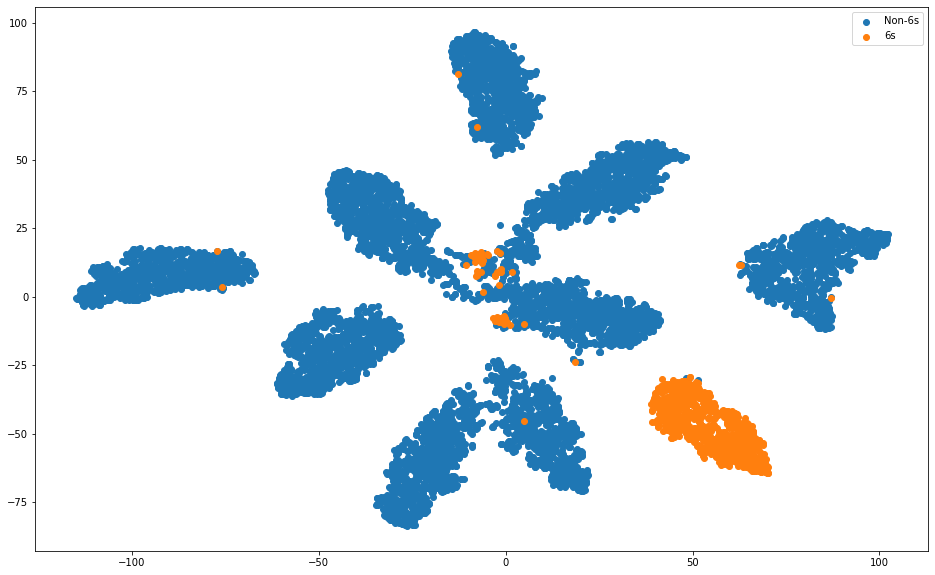

/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

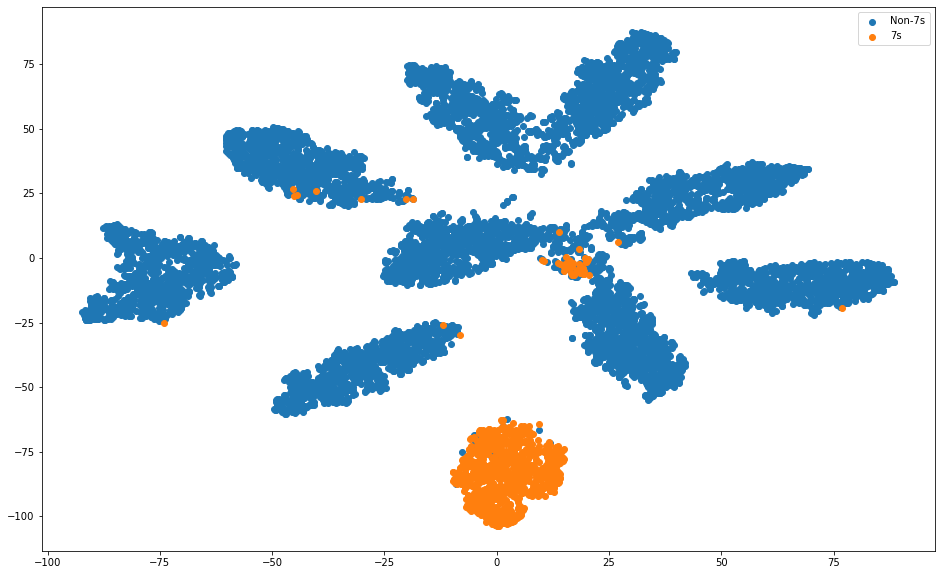

/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

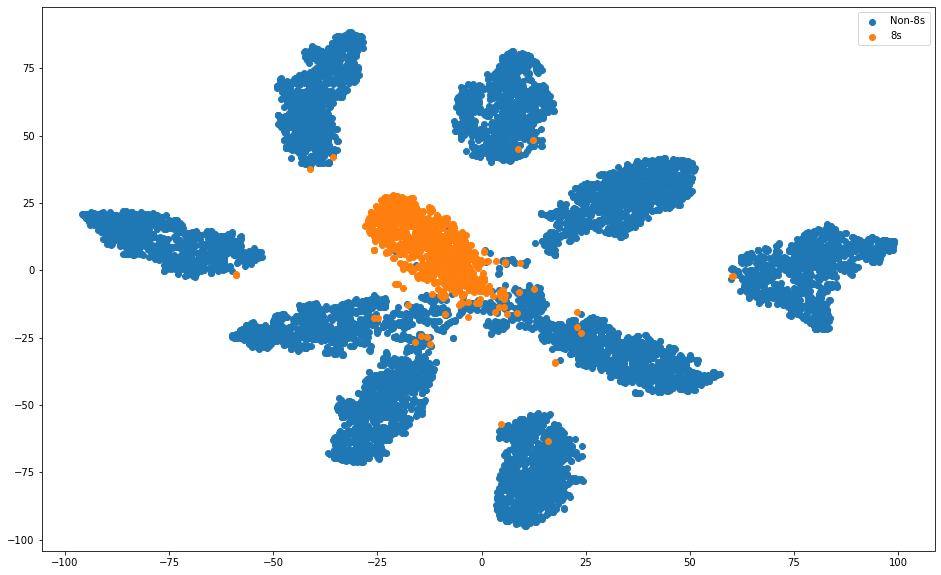

/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

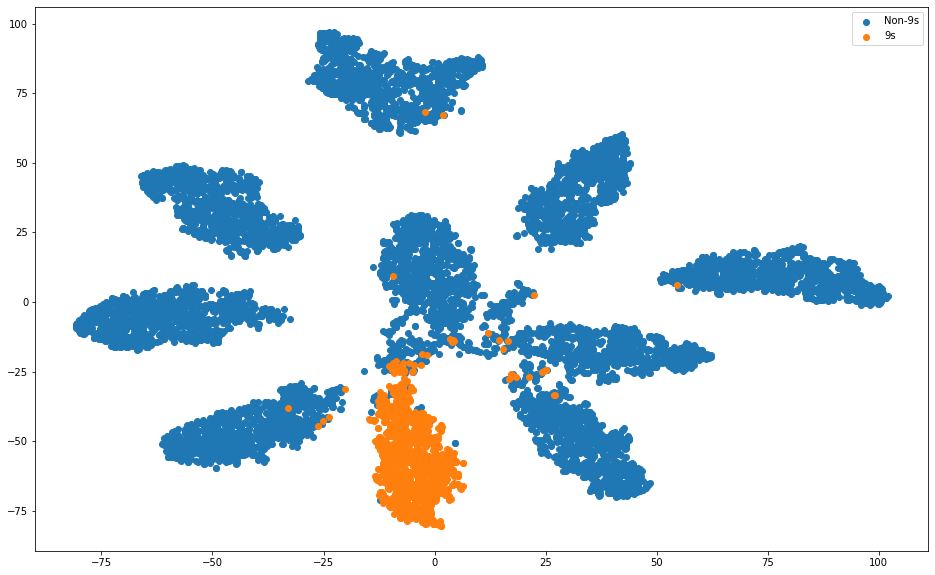

<Figure size 432x288 with 0 Axes>

In [13]:
tsne = TSNE(n_components=2, perplexity = 50, n_iter = 2000)
for digit in range(10):
    test, test_labels = one_vs_all_digits(X_test, y_test, model, digit)
    tsne_points = tsne.fit_transform(test)
    
    boundary = len(test_labels) - test_labels.sum().item()

    plt.figure(figsize=(16,10))
    plt.scatter(tsne_points[:boundary,0], tsne_points[:boundary,1], label="Non-" + str(digit) + "s")
    plt.scatter(tsne_points[boundary:,0], tsne_points[boundary:,1], label=str(digit) + "s")
    plt.legend()
    plt.savefig('Images/mnist_model_outputs-' + str(digit) + '-vs-others-tsne_map.png')
    plt.show()

In [24]:
from sklearn.svm import LinearSVC, SVC

In [26]:
tsne = TSNE(n_components=2, perplexity = 50, n_iter = 2000)

train, train_labels = one_vs_all_digits(X_train, y_train, model, digit)
test, test_labels = one_vs_all_digits(X_test, y_test, model, digit)
tsne_points = tsne.fit_transform(train)
tsne_test = tsne.fit_transform(test)

/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


# Once we have created the tsne points, we plot them and try to figure out what the SVM plane looks like 

/home/aditya/anaconda3/envs/torch-dev/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


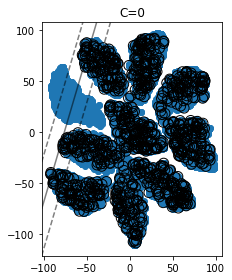

In [42]:
linear_clf = LinearSVC(loss='hinge', random_state=42, C=100, max_iter = 1e8).fit(tsne_points, train_labels)
decision_function = linear_clf.decision_function(tsne_test)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = tsne_points[support_vector_indices]
plt.subplot(1, 2, 1)
plt.scatter(tsne_points[:, 0], tsne_points[:, 1], cmap=plt.cm.Paired)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
)
Z = linear_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(
    xx,
    yy,
    Z,
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
)
plt.scatter(
    support_vectors[:, 0],
    support_vectors[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.title("C=" + str(0))
    
plt.tight_layout()
plt.show()

In [14]:
# linear_clf = LinearSVC().fit(train, train_labels)
# clf = SVC().fit(train, train_labels)

In [15]:
# print(linear_clf.score(test, test_labels))
# print(clf.score(test, test_labels))